# Deep Reinforcement Learning for Portfolio Optimization - EI3 (Inception) Architecture


This experiement demonstrates the application of deep reinforcement learning (DRL) techniques for portfolio optimization.

- Policy network architecture: **EI3 (Inception) backbone**
- Compares `A2C`, `PPO`, `SAC`, `DDPG`, `TD3` all with simple MLPs

## Dependencies


In [2]:
# ! pip install pandas numpy matplotlib \
#                stable-baselines3 \
#                PyPortfolioOpt \
#                pandas_market_calendars quantstats gymnasium \
#                git+https://github.com/AI4Finance-Foundation/FinRL.git -q

In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from scipy.optimize import minimize

import torch

from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import (
    PortfolioOptimizationEnv,
)
from finrl.agents.portfolio_optimization.models import DRLAgent as POAgent
from finrl.agents.portfolio_optimization.architectures import EI3

In [4]:
import warnings

# warnings.filterwarnings("ignore")

%matplotlib inline

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
experiment_name = "ei3_pg"
results_dir = f"results/models/{experiment_name}"
os.makedirs(results_dir, exist_ok=True)

## Data loading and pre-processing


Define training and trading/test periods


In [7]:
start_date = "2015-01-01"
end_date = (datetime.now() - pd.Timedelta(days=1)).strftime("%Y-%m-%d")  # Yesterday

trade_period = 2  # 2 years for testing
train_period = 10  # 10 years for training

train_end_date = (
    datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days=trade_period * 365)
).strftime("%Y-%m-%d")
train_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") - timedelta(days=train_period * 365)
).strftime("%Y-%m-%d")
test_start_date = (
    datetime.strptime(train_end_date, "%Y-%m-%d") + timedelta(days=1)
).strftime("%Y-%m-%d")

train_dates = (train_start_date, train_end_date)
test_dates = (test_start_date, end_date)

print(f"Training period: {train_dates}")
print(f"Testing period: {test_dates}")

Training period: ('2013-05-02', '2023-04-30')
Testing period: ('2023-05-01', '2025-04-29')


- Fetch historical stock data for a given list of tickers within a specified date range.
- We use the DOW_30_TICKER stocks
- The data includes `date`, `close`, `high`, `low`, `open`, `volume`, and `tic` (ticker symbol).


In [8]:
def download_data(tickers, start_date, end_date):
    print(f"Downloading {start_date} → {end_date}")
    return YahooDownloader(
        start_date=start_date, end_date=end_date, ticker_list=tickers
    ).fetch_data()


tickers = config_tickers.DOW_30_TICKER

raw_df = download_data(tickers, start_date, end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (76791, 8)


---

### Feature Engineering

We apply feature engineering to the dataset of stock data:

- Add technical indicators (e.g., moving averages, RSI).
- Calculate turbulence indicators, which measure market volatility.

This Enhance the dataset with features that are critical for modeling market dynamics and making informed trading decisions.


In [ ]:
def preprocess_data(df):
    fe = FeatureEngineer(use_technical_indicator=True, use_turbulence=True)
    return fe.preprocess_data(df)


df_feat = preprocess_data(raw_df)

Successfully added technical indicators
Successfully added turbulence index


## Covariance & Returns for State


- Calculate the rolling covariance matrices and daily returns for the given dataset of stock prices.
- This prepares the state representation (the state of the portfolio) for the RL models in the RL environments for portfolio optimization.
- The **rolling covariance matrices** (`cov_list`) capture the relationships between asset returns, while the daily returns (`return_list`) provide information about recent price movements.
- These metrics are critical for modeling the dynamics of the financial market and making informed trading decisions.


In [10]:
def compute_covariance_and_returns(df_feat, lookback=252):
    df_sorted = df_feat.sort_values(["date", "tic"], ignore_index=True)
    df_sorted.index = df_sorted.date.factorize()[0]
    cov_list, return_list = [], []

    dates = df_sorted.date.unique()
    for i in range(lookback, len(dates)):
        win = df_sorted.loc[i - lookback : i]
        pm = win.pivot_table(index="date", columns="tic", values="close")
        rm = pm.pct_change().dropna()
        cov_list.append(rm.cov().values)
        return_list.append(rm)
    df_cov = pd.DataFrame(
        {"date": dates[lookback:], "cov_list": cov_list, "return_list": return_list}
    )

    return pd.merge(df_feat, df_cov, on="date", how="left").dropna(subset=["cov_list"])


df_all = compute_covariance_and_returns(df_feat)

## Train/Trade split


In [11]:
def split_data(df_all, train_dates, test_dates):
    train = data_split(df_all, *train_dates)
    test = data_split(df_all, *test_dates)
    return train, test


train_df, test_df = split_data(df_all, train_dates, test_dates)

## Environment setup


- Create instances of the **PortfolioOptimizationEnv** class for both training and testing datasets.
- It also wrap the training environment for use with Stable-Baselines3 (SB3).


In [12]:
def initialize_portfolio_env(df):
    env = PortfolioOptimizationEnv(
        df,
        initial_amount=100_000,
        comission_fee_pct=0.0025,
        time_window=50,
        features=["close", "high", "low"],
        normalize_df=None,
        new_gym_api=True,
    )

    env.df = df.reset_index(drop=True)

    return env


train_env = initialize_portfolio_env(train_df)

## Training


- Set PolicyGradient algorithm and EIIE architecture arguments


In [ ]:
model_kwargs = {"lr": 0.01, "policy": EI3, "device": device}
# Set EI3 architecture arguments
policy_kwargs = {
    "k_short": 3,  # short‐term conv kernel
    "k_medium": 21,  # medium‐term conv kernel
    "conv_mid_features": 3,  # intermediate channels
    "conv_final_features": 20,
    "time_window": 50,  # same as PortfolioOptimizationEnv(time_window)
    "device": device,
}
model = POAgent(train_env).get_model("pg", device, model_kwargs, policy_kwargs)

- Train the model


In [36]:
def train():
    start_time = time.time()

    trained_model = POAgent.train_model(model, episodes=50)

    end_time = time.time()
    training_duration = (end_time - start_time) / 60
    print(f"Training completed in {training_duration:.2f} minutes.")
    
    return trained_model, training_duration

In [ ]:
# TODO: Turn to False after first run to avoid retraining and just analyse the results
retrain = True

model_path = f"{results_dir}/ei3_pg.pth"

In [39]:
if retrain:
    trained_model, training_duration = train()

  0%|          | 0/50 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 138042.734375
Final accumulative portfolio value: 1.380427360534668
Maximum DrawDown: -0.779200528897737
Sharpe ratio: 0.30453129536164725


  2%|▏         | 1/50 [00:18<15:27, 18.93s/it]

Initial portfolio value:100000
Final portfolio value: 151635.875
Final accumulative portfolio value: 1.516358733177185
Maximum DrawDown: -0.7910647715757454
Sharpe ratio: 0.34834713023421093


  4%|▍         | 2/50 [00:37<14:46, 18.46s/it]

Initial portfolio value:100000
Final portfolio value: 179743.15625
Final accumulative portfolio value: 1.7974315881729126
Maximum DrawDown: -0.7792004727080977
Sharpe ratio: 0.41409738899877474


  6%|▌         | 3/50 [00:59<15:58, 20.40s/it]

Initial portfolio value:100000
Final portfolio value: 183240.578125
Final accumulative portfolio value: 1.8324058055877686
Maximum DrawDown: -0.7792003352379573
Sharpe ratio: 0.41988567020220086


  8%|▊         | 4/50 [01:18<15:10, 19.80s/it]

Initial portfolio value:100000
Final portfolio value: 178212.90625
Final accumulative portfolio value: 1.7821290493011475
Maximum DrawDown: -0.7792004206051385
Sharpe ratio: 0.4086754000942538


 10%|█         | 5/50 [01:37<14:31, 19.37s/it]

Initial portfolio value:100000
Final portfolio value: 177468.953125
Final accumulative portfolio value: 1.7746895551681519
Maximum DrawDown: -0.7792004532572748
Sharpe ratio: 0.4070326432465952


 12%|█▏        | 6/50 [01:54<13:42, 18.70s/it]

Initial portfolio value:100000
Final portfolio value: 180898.328125
Final accumulative portfolio value: 1.808983325958252
Maximum DrawDown: -0.7792003815673549
Sharpe ratio: 0.41478916250027204


 14%|█▍        | 7/50 [02:12<13:18, 18.56s/it]

Initial portfolio value:100000
Final portfolio value: 239890.421875
Final accumulative portfolio value: 2.398904323577881
Maximum DrawDown: -0.7792004219630673
Sharpe ratio: 0.5346526232505787


 16%|█▌        | 8/50 [02:31<12:54, 18.44s/it]

Initial portfolio value:100000
Final portfolio value: 228386.4375
Final accumulative portfolio value: 2.2838642597198486
Maximum DrawDown: -0.7792004306070495
Sharpe ratio: 0.5157979558094637


 18%|█▊        | 9/50 [02:49<12:31, 18.32s/it]

Initial portfolio value:100000
Final portfolio value: 196195.515625
Final accumulative portfolio value: 1.961955189704895
Maximum DrawDown: -0.7792004114278133
Sharpe ratio: 0.4582447263286739


 20%|██        | 10/50 [03:08<12:21, 18.54s/it]

Initial portfolio value:100000
Final portfolio value: 203055.4375
Final accumulative portfolio value: 2.0305542945861816
Maximum DrawDown: -0.7792003426447314
Sharpe ratio: 0.4732351239877285


 22%|██▏       | 11/50 [03:27<12:07, 18.66s/it]

Initial portfolio value:100000
Final portfolio value: 232489.03125
Final accumulative portfolio value: 2.324890375137329
Maximum DrawDown: -0.7792003843858188
Sharpe ratio: 0.5232643148782166


 24%|██▍       | 12/50 [03:45<11:48, 18.65s/it]

Initial portfolio value:100000
Final portfolio value: 179608.6875
Final accumulative portfolio value: 1.7960869073867798
Maximum DrawDown: -0.7792004384272683
Sharpe ratio: 0.41171183083662716


 26%|██▌       | 13/50 [04:03<11:17, 18.30s/it]

Initial portfolio value:100000
Final portfolio value: 170892.828125
Final accumulative portfolio value: 1.7089282274246216
Maximum DrawDown: -0.7792003525292056
Sharpe ratio: 0.3917379114327363


 28%|██▊       | 14/50 [04:21<10:53, 18.16s/it]

Initial portfolio value:100000
Final portfolio value: 174343.390625
Final accumulative portfolio value: 1.743433952331543
Maximum DrawDown: -0.7792004554079697
Sharpe ratio: 0.3997744581384181


 30%|███       | 15/50 [04:39<10:41, 18.33s/it]

Initial portfolio value:100000
Final portfolio value: 172903.6875
Final accumulative portfolio value: 1.7290369272232056
Maximum DrawDown: -0.7792004123505315
Sharpe ratio: 0.39643442741403756


 32%|███▏      | 16/50 [04:58<10:22, 18.32s/it]

Initial portfolio value:100000
Final portfolio value: 184932.609375
Final accumulative portfolio value: 1.8493261337280273
Maximum DrawDown: -0.7792005080544421
Sharpe ratio: 0.4234158789573155


 34%|███▍      | 17/50 [05:17<10:18, 18.74s/it]

Initial portfolio value:100000
Final portfolio value: 187070.5
Final accumulative portfolio value: 1.870705008506775
Maximum DrawDown: -0.7792004160044692
Sharpe ratio: 0.4280450987982466


 36%|███▌      | 18/50 [05:35<09:53, 18.54s/it]

Initial portfolio value:100000
Final portfolio value: 188028.0625
Final accumulative portfolio value: 1.880280613899231
Maximum DrawDown: -0.7792004130984387
Sharpe ratio: 0.4301005713784056


 38%|███▊      | 19/50 [05:53<09:27, 18.31s/it]

Initial portfolio value:100000
Final portfolio value: 187307.078125
Final accumulative portfolio value: 1.8730708360671997
Maximum DrawDown: -0.7792003795107596
Sharpe ratio: 0.42853459378357645


 40%|████      | 20/50 [06:11<09:08, 18.27s/it]

Initial portfolio value:100000
Final portfolio value: 187294.421875
Final accumulative portfolio value: 1.8729442358016968
Maximum DrawDown: -0.7792005089727588
Sharpe ratio: 0.42850812486124235


 42%|████▏     | 21/50 [06:29<08:44, 18.08s/it]

Initial portfolio value:100000
Final portfolio value: 187347.015625
Final accumulative portfolio value: 1.8734701871871948
Maximum DrawDown: -0.7792003445770088
Sharpe ratio: 0.42862151793167524


 44%|████▍     | 22/50 [06:47<08:23, 17.98s/it]

Initial portfolio value:100000
Final portfolio value: 187610.0
Final accumulative portfolio value: 1.876099944114685
Maximum DrawDown: -0.7792005258571247
Sharpe ratio: 0.42919230810115905


 46%|████▌     | 23/50 [07:05<08:09, 18.12s/it]

Initial portfolio value:100000
Final portfolio value: 187917.359375
Final accumulative portfolio value: 1.8791736364364624
Maximum DrawDown: -0.779200366740935
Sharpe ratio: 0.4298648501811955


 48%|████▊     | 24/50 [07:24<07:57, 18.36s/it]

Initial portfolio value:100000
Final portfolio value: 187429.75
Final accumulative portfolio value: 1.8742974996566772
Maximum DrawDown: -0.7792003216965806
Sharpe ratio: 0.4288050405086966


 50%|█████     | 25/50 [07:43<07:42, 18.49s/it]

Initial portfolio value:100000
Final portfolio value: 187837.0
Final accumulative portfolio value: 1.8783700466156006
Maximum DrawDown: -0.7792005351629131
Sharpe ratio: 0.4296930522250637


 52%|█████▏    | 26/50 [08:02<07:30, 18.77s/it]

Initial portfolio value:100000
Final portfolio value: 188224.625
Final accumulative portfolio value: 1.8822462558746338
Maximum DrawDown: -0.7792004391676535
Sharpe ratio: 0.4305229986585723


 54%|█████▍    | 27/50 [08:23<07:21, 19.21s/it]

Initial portfolio value:100000
Final portfolio value: 188114.765625
Final accumulative portfolio value: 1.8811476230621338
Maximum DrawDown: -0.7792003942011996
Sharpe ratio: 0.4302875863097059


 56%|█████▌    | 28/50 [08:41<06:59, 19.06s/it]

Initial portfolio value:100000
Final portfolio value: 187324.65625
Final accumulative portfolio value: 1.8732465505599976
Maximum DrawDown: -0.7792006381467297
Sharpe ratio: 0.428574023934384


 58%|█████▊    | 29/50 [09:00<06:35, 18.84s/it]

Initial portfolio value:100000
Final portfolio value: 187575.703125
Final accumulative portfolio value: 1.8757569789886475
Maximum DrawDown: -0.7792003966211463
Sharpe ratio: 0.42912351482693817


 60%|██████    | 30/50 [09:17<06:09, 18.49s/it]

Initial portfolio value:100000
Final portfolio value: 188273.3125
Final accumulative portfolio value: 1.8827331066131592
Maximum DrawDown: -0.7792004412816511
Sharpe ratio: 0.4306260482214821


 62%|██████▏   | 31/50 [09:36<05:50, 18.42s/it]

Initial portfolio value:100000
Final portfolio value: 188383.53125
Final accumulative portfolio value: 1.8838353157043457
Maximum DrawDown: -0.77920038864806
Sharpe ratio: 0.43086178206068304


 64%|██████▍   | 32/50 [09:54<05:32, 18.48s/it]

Initial portfolio value:100000
Final portfolio value: 188206.375
Final accumulative portfolio value: 1.8820637464523315
Maximum DrawDown: -0.7792004715195509
Sharpe ratio: 0.4304800693019265


 66%|██████▌   | 33/50 [10:12<05:10, 18.26s/it]

Initial portfolio value:100000
Final portfolio value: 187086.21875
Final accumulative portfolio value: 1.8708622455596924
Maximum DrawDown: -0.7792005178455146
Sharpe ratio: 0.42807823366096637


 68%|██████▊   | 34/50 [10:30<04:52, 18.27s/it]

Initial portfolio value:100000
Final portfolio value: 188046.609375
Final accumulative portfolio value: 1.880466103553772
Maximum DrawDown: -0.7792004805677009
Sharpe ratio: 0.4301260995364573


 70%|███████   | 35/50 [10:48<04:32, 18.14s/it]

Initial portfolio value:100000
Final portfolio value: 187439.609375
Final accumulative portfolio value: 1.8743960857391357
Maximum DrawDown: -0.779200351003507
Sharpe ratio: 0.42883867965535033


 74%|███████▍  | 37/50 [11:22<03:49, 17.64s/it]

Initial portfolio value:100000
Final portfolio value: 187495.1875
Final accumulative portfolio value: 1.8749518394470215
Maximum DrawDown: -0.77920040598411
Sharpe ratio: 0.4289445941108054


 76%|███████▌  | 38/50 [11:41<03:35, 17.92s/it]

Initial portfolio value:100000
Final portfolio value: 188343.828125
Final accumulative portfolio value: 1.883438229560852
Maximum DrawDown: -0.7792003850434691
Sharpe ratio: 0.4307764946465634


 78%|███████▊  | 39/50 [11:58<03:13, 17.55s/it]

Initial portfolio value:100000
Final portfolio value: 187506.609375
Final accumulative portfolio value: 1.8750660419464111
Maximum DrawDown: -0.7792003379825315
Sharpe ratio: 0.42898471398778637


 80%|████████  | 40/50 [12:14<02:52, 17.29s/it]

Initial portfolio value:100000
Final portfolio value: 192661.265625
Final accumulative portfolio value: 1.9266126155853271
Maximum DrawDown: -0.7792004124609087
Sharpe ratio: 0.43988309385905416


 82%|████████▏ | 41/50 [12:31<02:33, 17.10s/it]

Initial portfolio value:100000
Final portfolio value: 197463.703125
Final accumulative portfolio value: 1.9746370315551758
Maximum DrawDown: -0.7792004298353881
Sharpe ratio: 0.44974465300133587


 84%|████████▍ | 42/50 [12:48<02:15, 16.92s/it]

Initial portfolio value:100000
Final portfolio value: 207802.109375
Final accumulative portfolio value: 2.0780210494995117
Maximum DrawDown: -0.7792004928999797
Sharpe ratio: 0.4703289015586569


 86%|████████▌ | 43/50 [13:04<01:57, 16.81s/it]

Initial portfolio value:100000
Final portfolio value: 185742.96875
Final accumulative portfolio value: 1.8574297428131104
Maximum DrawDown: -0.7792004226582807
Sharpe ratio: 0.42758314469282466


 88%|████████▊ | 44/50 [13:21<01:40, 16.81s/it]

Initial portfolio value:100000
Final portfolio value: 188473.84375
Final accumulative portfolio value: 1.8847384452819824
Maximum DrawDown: -0.7792004435092719
Sharpe ratio: 0.4335651652918788
Initial portfolio value:100000
Final portfolio value: 188473.84375
Final accumulative portfolio value: 1.8847384452819824
Maximum DrawDown: -0.7792004435092719
Sharpe ratio: 0.4335651901028924


 92%|█████████▏| 46/50 [13:55<01:07, 16.90s/it]

Initial portfolio value:100000
Final portfolio value: 188473.84375
Final accumulative portfolio value: 1.8847384452819824
Maximum DrawDown: -0.7792004435092719
Sharpe ratio: 0.43356506530549466
Initial portfolio value:100000
Final portfolio value: 188473.84375
Final accumulative portfolio value: 1.8847384452819824
Maximum DrawDown: -0.7792004435092719
Sharpe ratio: 0.4335650662396272


 94%|█████████▍| 47/50 [14:13<00:51, 17.18s/it]

Initial portfolio value:100000
Final portfolio value: 188473.84375
Final accumulative portfolio value: 1.8847384452819824
Maximum DrawDown: -0.7792004435092719
Sharpe ratio: 0.4335651399563573


 98%|█████████▊| 49/50 [14:47<00:17, 17.22s/it]

Initial portfolio value:100000
Final portfolio value: 188473.84375
Final accumulative portfolio value: 1.8847384452819824
Maximum DrawDown: -0.7792004435092719
Sharpe ratio: 0.4335652170543368


100%|██████████| 50/50 [15:04<00:00, 18.09s/it]

Initial portfolio value:100000
Final portfolio value: 188473.84375
Final accumulative portfolio value: 1.8847384452819824
Maximum DrawDown: -0.7792004435092719
Sharpe ratio: 0.4335650662396272
Training completed in 15.07 minutes.


In [40]:
if retrain:
    # Save the trained model
    torch.save(trained_model.train_policy.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    # Save training times
    training_times_df = pd.DataFrame(
        [{"model": "EI3_PG", "training_duration (min)": training_duration}]
    )
    training_times_df.to_csv(f"{results_dir}/training_times.csv", index=False)

    # Display training summary
    print("Training summary:")
    display(training_times_df)

Model saved to results/models/portfolio_optimization_ei3_pg/ei3_pg.pth
Training summary:


,model,training_duration (min)
0,EI3_PG,15.073516


## Backtesting


In [41]:
policy = EI3(time_window=50, device=device)
policy.load_state_dict(torch.load(model_path, map_location=device))
# policy = policy.to(device)
# policy.eval()
print("Model loaded and ready for evaluation.")
print("Evaluating model on test data...")

test_env = initialize_portfolio_env(test_df.reset_index(drop=True))

Model loaded and ready for evaluation.
Evaluating model on test data...


In [42]:
def portfolio_test(env, policy, initial_last_action=None):
    obs, _ = env.reset()
    obs = np.asarray(obs, dtype=np.float32)

    # Initial last_action
    if initial_last_action is None:
        action_dim = env.action_space.shape[0]
        last_action = np.ones(action_dim, dtype=np.float32) / action_dim
    else:
        last_action = np.asarray(initial_last_action).flatten().astype(np.float32)

    done = False
    transitions = []

    while not done:
        # Create batches
        obs_batch = obs[None, ...]
        la_batch = last_action[None, ...]

        # Policy forward
        action = policy(obs_batch, la_batch)
        action = np.asarray(action).flatten().astype(np.float32)

        # Step
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = bool(terminated or truncated)

        next_obs = np.asarray(next_obs, dtype=np.float32)

        # Record
        transitions.append(
            {
                "obs": obs,
                "last_action": last_action,
                "action": action,
                "reward": float(reward),
                "info": info,
            }
        )

        # Advance
        obs = next_obs
        last_action = action

    return transitions


transitions = portfolio_test(test_env, policy)

print(f"Collected {len(transitions)} steps.")
print("Rewards:", [t["reward"] for t in transitions])

Initial portfolio value:100000
Final portfolio value: 109534.6953125
Final accumulative portfolio value: 1.0953469276428223
Maximum DrawDown: -0.3431969836387455
Sharpe ratio: 0.32032409361812314
Collected 451 steps.
Rewards: [-0.008783236145973206, 0.0699051022529602, 0.008110091090202332, 0.03235789015889168, 0.007372790016233921, 0.0010714748641476035, 0.004531234968453646, 0.004235464613884687, 0.004413388203829527, -0.005751128774136305, -0.005467612762004137, -0.004602637141942978, 0.006856485269963741, -0.0032242005690932274, 0.00011884459672728553, 0.00011884459672728553, -0.004227920435369015, 0.015807321295142174, -0.009600683115422726, -0.007440762594342232, 0.00272486568428576, 0.008957086130976677, 0.005731339566409588, -0.00833314098417759, -0.006196584552526474, -0.019248252734541893, 0.009028680622577667, -0.001525969710201025, -0.010787769220769405, -0.005907546263188124, -0.002741634612902999, 0.002087558386847377, 0.00440626684576273, 0.003150026546791196, -0.0026411

In [43]:
# Inspect rewards or info:
infosrewards = [t["reward"] for t in transitions]
infos = [t["info"] for t in transitions]

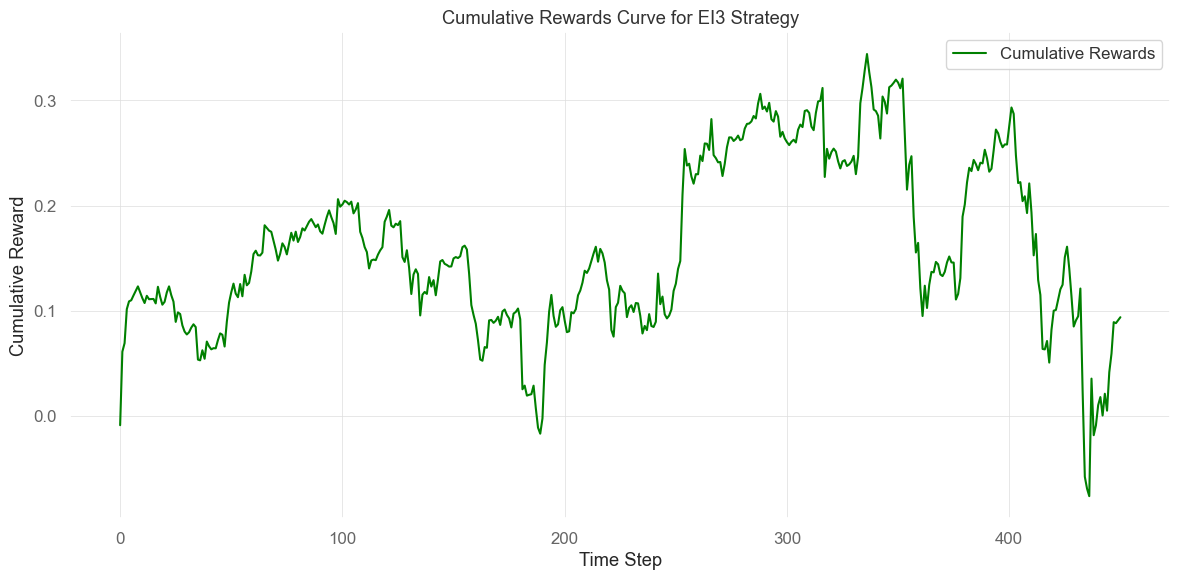

In [44]:
cumulative_rewards = np.cumsum(infosrewards)

# Plot the cumulative rewards curve
plt.figure(figsize=(12, 6))
plt.plot(cumulative_rewards, label="Cumulative Rewards", color="green")
plt.title("Cumulative Rewards Curve for EI3 Strategy")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
plt.close()

## Benchmarks


In [45]:
# Get portfolio values
eiie_values = test_env._asset_memory["final"]
bh_values = []

In [46]:
# Calculate Buy & Hold
test_env.reset()
action = [1 / len(tickers)] * len(tickers)
done = False
while not done:  # Use test_env._done to check episode completion
    test_obs, rewards, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated
    bh_values.append(test_env._portfolio_value)

Initial portfolio value:100000
Final portfolio value: 118570.15625
Final accumulative portfolio value: 1.185701608657837
Maximum DrawDown: -0.1432930207822235
Sharpe ratio: 0.7813436068389655


In [47]:
risk_free_rate = 0.043  # 4.3% annualized

In [48]:
# Calculate metrics
def calculate_metrics(values, risk_free_rate):
    returns = pd.Series(values).pct_change().dropna()
    cumulative_return = (values[-1] / values[0]) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility
    max_drawdown = (values / np.maximum.accumulate(values) - 1).min()

    return {
        "Cumulative Return": cumulative_return,
        "Annualized Return": annualized_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
    }


eiie_metrics = calculate_metrics(eiie_values, risk_free_rate)
bh_metrics = calculate_metrics(bh_values, risk_free_rate)

In [ ]:
metrics = [
    "Cumulative Return",
    "Annualized Return",
    "Volatility",
    "Sharpe Ratio",
    "Max Drawdown",
]

metrics_df = pd.DataFrame(
    {
        "Metric": metrics,
        "EI3": [eiie_metrics[m] for m in metrics],
        "Buy & Hold": [bh_metrics[m] for m in metrics],
    }
)

## Performance Summary


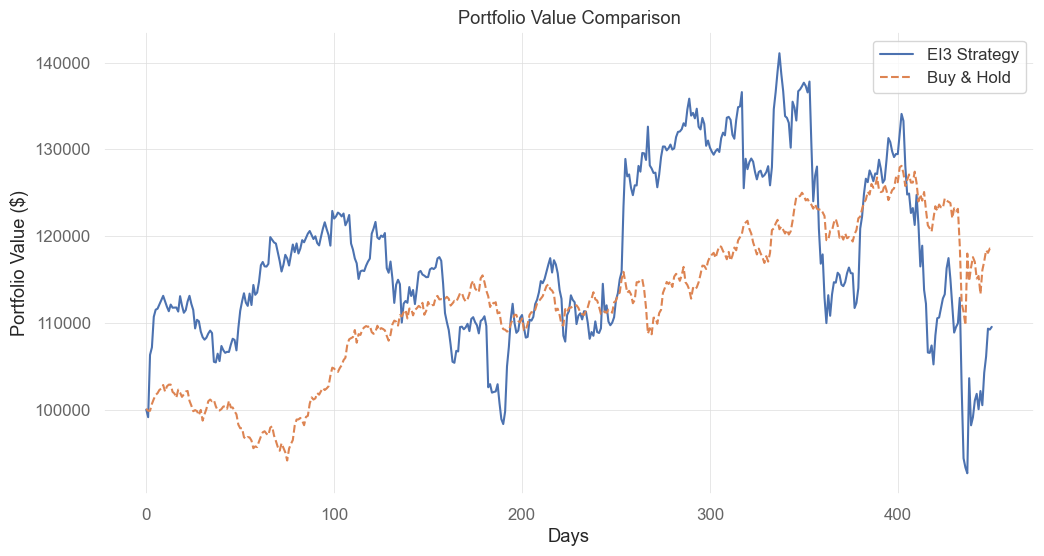

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(eiie_values, label="EI3 Strategy")
plt.plot(bh_values, label="Buy & Hold", linestyle="--")
plt.title("Portfolio Value Comparison")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()
plt.close()

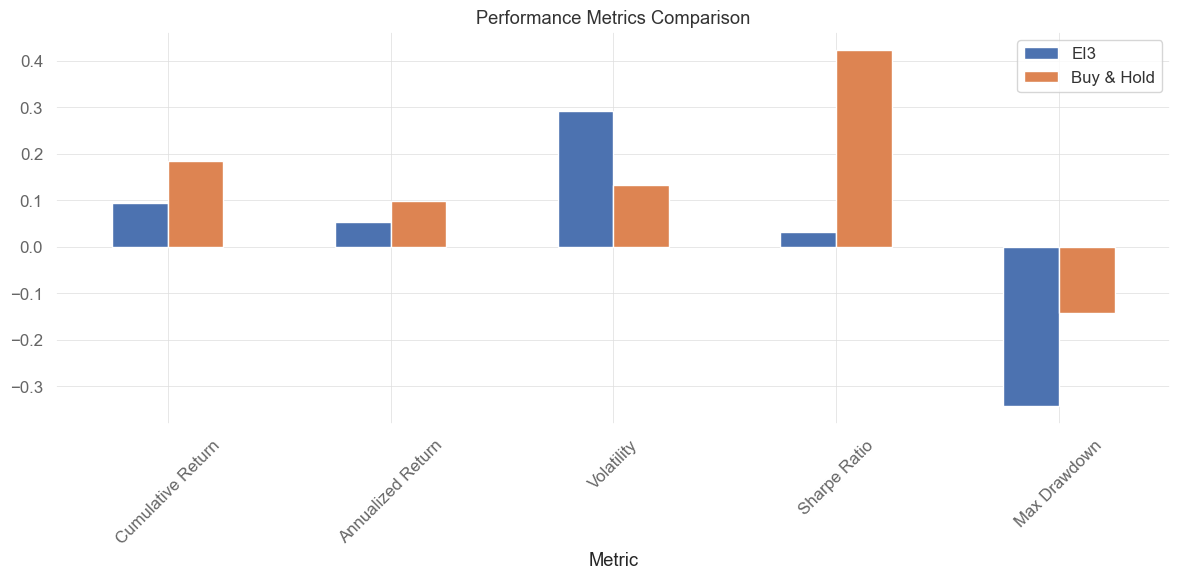

In [51]:
plt.figure(figsize=(12, 6))
metrics_df.set_index("Metric").plot(kind="bar", ax=plt.gca())
plt.title("Performance Metrics Comparison")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

In [55]:
# Display metrics
print("\nPerformance Metrics:")
display(
    metrics_df.style.format(
        {
            "EIIE": "{:.2%}",
            "Buy & Hold": "{:.2%}",
            "Sharpe Ratio": "{:.2f}",
            "Volatility": "{:.2%}",
        }
    )
)


Performance Metrics:


,Metric,EI3,Buy & Hold
0,Cumulative Return,0.095347,18.46%
1,Annualized Return,0.052323,9.95%
2,Volatility,0.291441,13.33%
3,Sharpe Ratio,0.031988,42.42%
4,Max Drawdown,-0.343197,-14.33%


In [ ]:
# Additional Sharpe ratio optimization
log_returns = raw_df.pivot_table(index="date", columns="tic", values="close")
log_returns = np.log(log_returns.pct_change() + 1).dropna()
cov_matrix = log_returns.cov() * 252

def negative_sharpe(weights):
    port_return = np.dot(weights, log_returns.mean()) * 252
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    return -(port_return - risk_free_rate) / port_vol


constraints = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
bounds = [(0, 1) for _ in tickers]
initial_weights = np.array([1 / len(tickers)] * len(tickers))

result = minimize(
    negative_sharpe,
    initial_weights,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
)

print("\nOptimal Weights from Sharpe Ratio Optimization:")
for ticker, weight in zip(tickers, result.x):
    print(f"{ticker}: {weight:.2%}")


Optimal Weights from Sharpe Ratio Optimization:
AXP: 34.19%
AMGN: 0.00%
AAPL: 0.00%
BA: 0.00%
CAT: 1.72%
CSCO: 0.00%
CVX: 0.00%
GS: 0.00%
HD: 0.00%
HON: 0.00%
IBM: 7.76%
INTC: 0.00%
JNJ: 0.00%
KO: 0.00%
JPM: 0.00%
MCD: 0.00%
MMM: 0.00%
MRK: 0.00%
MSFT: 0.00%
NKE: 0.00%
PG: 0.00%
TRV: 2.64%
UNH: 0.00%
CRM: 0.00%
VZ: 0.00%
V: 0.00%
WBA: 0.00%
WMT: 0.00%
DIS: 0.00%
DOW: 53.68%
